# Purpose

Create reproducible example for odeint from torchdiffeq, where the ODE system consists of state `x` and control `u`. 

The goal is to fit the parameters of the ODE using backpropagation with a torch optimizer.

The problem is that the fitted paramters do not approximate the true parameters well (when controls `u` are included).

In [1]:
import sys
import torch
import torchdiffeq
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def input_interp(t, timepoints, input_vals):
    """Custom forward interpolating function without numpy"""
    
    assert len(input_vals) == len(timepoints)

    # Get list indicating if t <= tp fpr all tp in timepoints
    t_smaller_time = [1 if t <= tp else 0 for tp in timepoints]
    
    # Return value corresponding to first tp that fulfills t <= tp
    if any(t_smaller_time):
        idx_last_value = t_smaller_time.index(1)
        val_interp = input_vals[idx_last_value]
    # Return last value if there is no tp that fulfills t <= tp
    else:
        val_interp = input_vals[len(input_vals)-1]
    
    return val_interp

In [3]:
# Print versions
print(torch.__version__)
print(torchdiffeq.__version__)
print(sys.version)

1.6.0
0.1.1
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]


## Preparations

In [4]:
# Prepare true parameters, initial value, timepoints
true_params = torch.tensor([10.0, 10.0, 0.5], requires_grad = True)
x0 = torch.tensor(0.001).float()
timepoints = torch.tensor(np.arange(0, 30 * 1.0))

In [5]:
# Prepare sequence of controls u and corresponding timepoints
u_vals = [0.75, 0] * 5 # length 10
u_time = np.arange(0, 35, 3.5) # length 10
assert len(u_vals) == len(u_time)

In [6]:
# Prepare ODE system
def system(t, x, u, params):
    return x * ((params[0] - x) / params[1] - params[2] * u)

In [7]:
# Prepare lambda function of ODE system, using interpolation of controls u
u_fun = lambda t: input_interp(t, u_time, u_vals)
rhs_fun = lambda t, x: system(t, x, u = u_fun(t),
                              params = true_params)

In [8]:
# Conduct forward simulation
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
x_true = torch.tensor(x.detach().numpy())

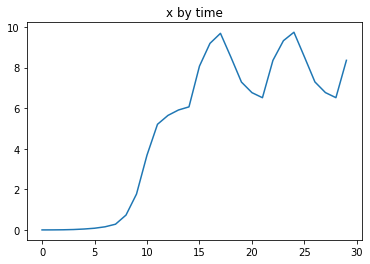

In [9]:
# Plot states x by time
plt.plot(timepoints, x_true);
plt.title("x by time");

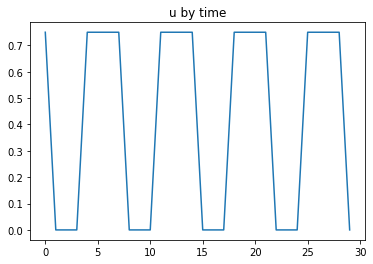

In [10]:
# Plot controls u by time
u_vals_interp = [u_fun(t) for t in timepoints]
plt.plot(timepoints, u_vals_interp);
plt.title("u by time");

## Fitting parameters with controls u


In [ ]:
# Initial parameters (true params are [10, 10, 0.5])
params = [torch.tensor(8.0, requires_grad = True), 
          torch.tensor(12.0, requires_grad = True), 
          torch.tensor(1.0, requires_grad = True)]

# Prepare optimizer, loss function, other params
optimizer = torch.optim.Adam(params, lr = 0.001)
loss_fun = torch.nn.MSELoss()
n_iter = 1000
loss_list = [0] * n_iter
time_total = 0

for i in range(n_iter):

    start_time = time.time()
    
    # Set gradients to zero to avoid gradient accumulation
    optimizer.zero_grad()

    # Get predicted state with current parameters using torchdiffeq.odeint 
    rhs_fun = lambda t, x: system(t, x, u = u_fun(t), params = params)
    x_pred = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
    
    # Compute loss and backpropagate gradients
    loss = loss_fun(x_pred, x_true)
    loss.backward()
    optimizer.step()

    # Print status
    end_time = time.time()
    time_delta = round(end_time - start_time)
    time_total += time_delta
    
    loss_list[i] = loss.item()
#     if i % 10 == 0:
#         print("\nIter {}/{} - Loss: {} - Time: {}s".format(i + 1, n_iter, 
#                                                          loss_list[i], 
#                                                          time_delta))
#         print([p.item() for p in params])
    

In [12]:
print("Time total: {}min".format(time_total/60))

Time total: 41.916666666666664min


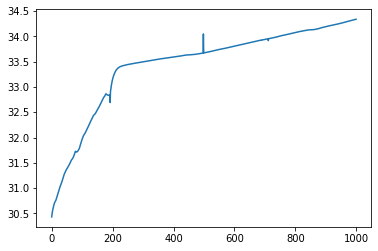

In [13]:
# Loss
plt.plot(loss_list);

[tensor(7.9671, requires_grad=True), tensor(12.0255, requires_grad=True), tensor(1.1221, requires_grad=True)]


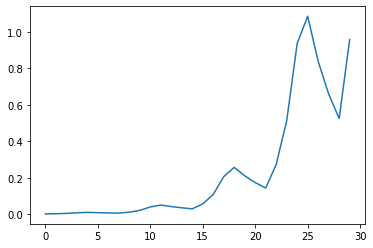

In [14]:
# Forward simulation with fitted values
u_fun = lambda t: input_interp(t, u_time, u_vals)
rhs_fun = lambda t, x: system(t, x, u = u_fun(t),
                              params = params)
print(params)

# Conduct forward simulation
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
plt.plot(x.detach().numpy());

tensor([10.0000, 10.0000,  0.5000], requires_grad=True)


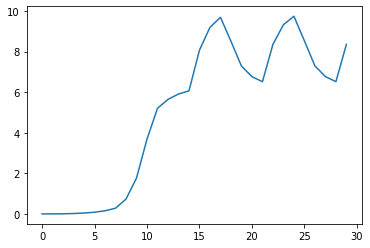

In [15]:
# Forward simulation with true values
u_fun = lambda t: input_interp(t, u_time, u_vals)
rhs_fun = lambda t, x: system(t, x, u = u_fun(t),
                              params = true_params)
print(true_params)

# Conduct forward simulation
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
plt.plot(x.detach().numpy());

## Fitting parameters without controls u

Here, we create a different ODE (where `u` is replaced with `x`). The remaining code is exactly the same. The results are noticeably better.

In [19]:
# Prepare adjusted ODE system
def system(t, x, params):
    return x * ((params[0] - x) / params[1] - params[2] * x)

In [20]:
# Conduct forward simulation
rhs_fun = lambda t, x: system(t, x, params = true_params)
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
x_true = torch.tensor(x.detach().numpy())

In [ ]:
# Initial parameters (true params are [10, 10, 0.5])
params = [torch.tensor(8.0, requires_grad = True), 
          torch.tensor(12.0, requires_grad = True), 
          torch.tensor(1.0, requires_grad = True)]

# Prepare optimizer, loss function, other params
optimizer = torch.optim.Adam(params, lr = 0.001)
loss_fun = torch.nn.MSELoss()
n_iter = 1000
loss_list = [0] * n_iter
time_total = 0

for i in range(n_iter):

    start_time = time.time()
    
    # Set gradients to zero to avoid gradient accumulation
    optimizer.zero_grad()

    # Get predicted state with current parameters using torchdiffeq.odeint 
    rhs_fun = lambda t, x: system(t, x, params = params)                     # ONLY THIS LINE ADJUSTED
    x_pred = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
    
    # Compute loss and backpropagate gradients
    loss = loss_fun(x_pred, x_true)
    loss.backward()
    optimizer.step()

    # Print status
    end_time = time.time()
    time_delta = round(end_time - start_time)
    time_total += time_delta
    
    loss_list[i] = loss.item()
#     if i % 10 == 0:
#         print("\nIter {}/{} - Loss: {} - Time: {}s".format(i + 1, n_iter, 
#                                                          loss_list[i], 
#                                                          time_delta))
#         print([p.item() for p in params])

In [22]:
print("Time total: {}min".format(time_total/60))

Time total: 4.0min


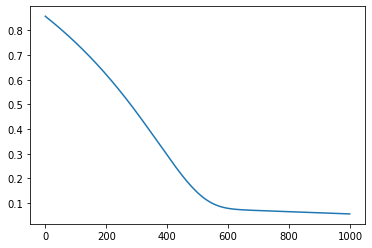

In [23]:
# Loss
plt.plot(loss_list);

[tensor(8.7517, requires_grad=True), tensor(11.2121, requires_grad=True), tensor(0.3640, requires_grad=True)]


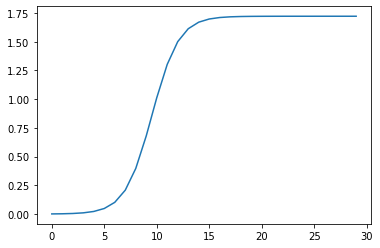

In [25]:
# Forward simulation with fitted values
rhs_fun = lambda t, x: system(t, x, params = params)
print(params)

# Conduct forward simulation
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
plt.plot(x.detach().numpy());

tensor([10.0000, 10.0000,  0.5000], requires_grad=True)


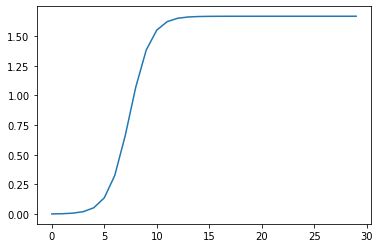

In [26]:
# Forward simulation with true values
u_fun = lambda t: input_interp(t, u_time, u_vals)
rhs_fun = lambda t, x: system(t, x, 
                              params = true_params)
print(true_params)

# Conduct forward simulation
x = torchdiffeq.odeint(rhs_fun, x0, timepoints, method = "dopri5")
plt.plot(x.detach().numpy());